In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from scipy.signal import periodogram

# Load timeseries data

In [3]:
# load water data
water_data = pd.read_csv("water_consumption_data/water.csv")

# Set date as index
water_data["Datetime"] = pd.to_datetime(water_data["Datetime"])
water_data = water_data.set_index("Datetime")

water_data.head(25)

,Consumption
Datetime,
2002-01-01 01:00:00,30393
2002-01-01 02:00:00,29265
2002-01-01 03:00:00,28357
2002-01-01 04:00:00,27899
2002-01-01 05:00:00,28057
2002-01-01 06:00:00,28654
2002-01-01 07:00:00,29308
2002-01-01 08:00:00,29595
2002-01-01 09:00:00,29943


# Plot timeseries

We plot the timeseries on hourly, daily, and weekly frequency. The last two aggreagate the values of every 24 and 168 hours respectively

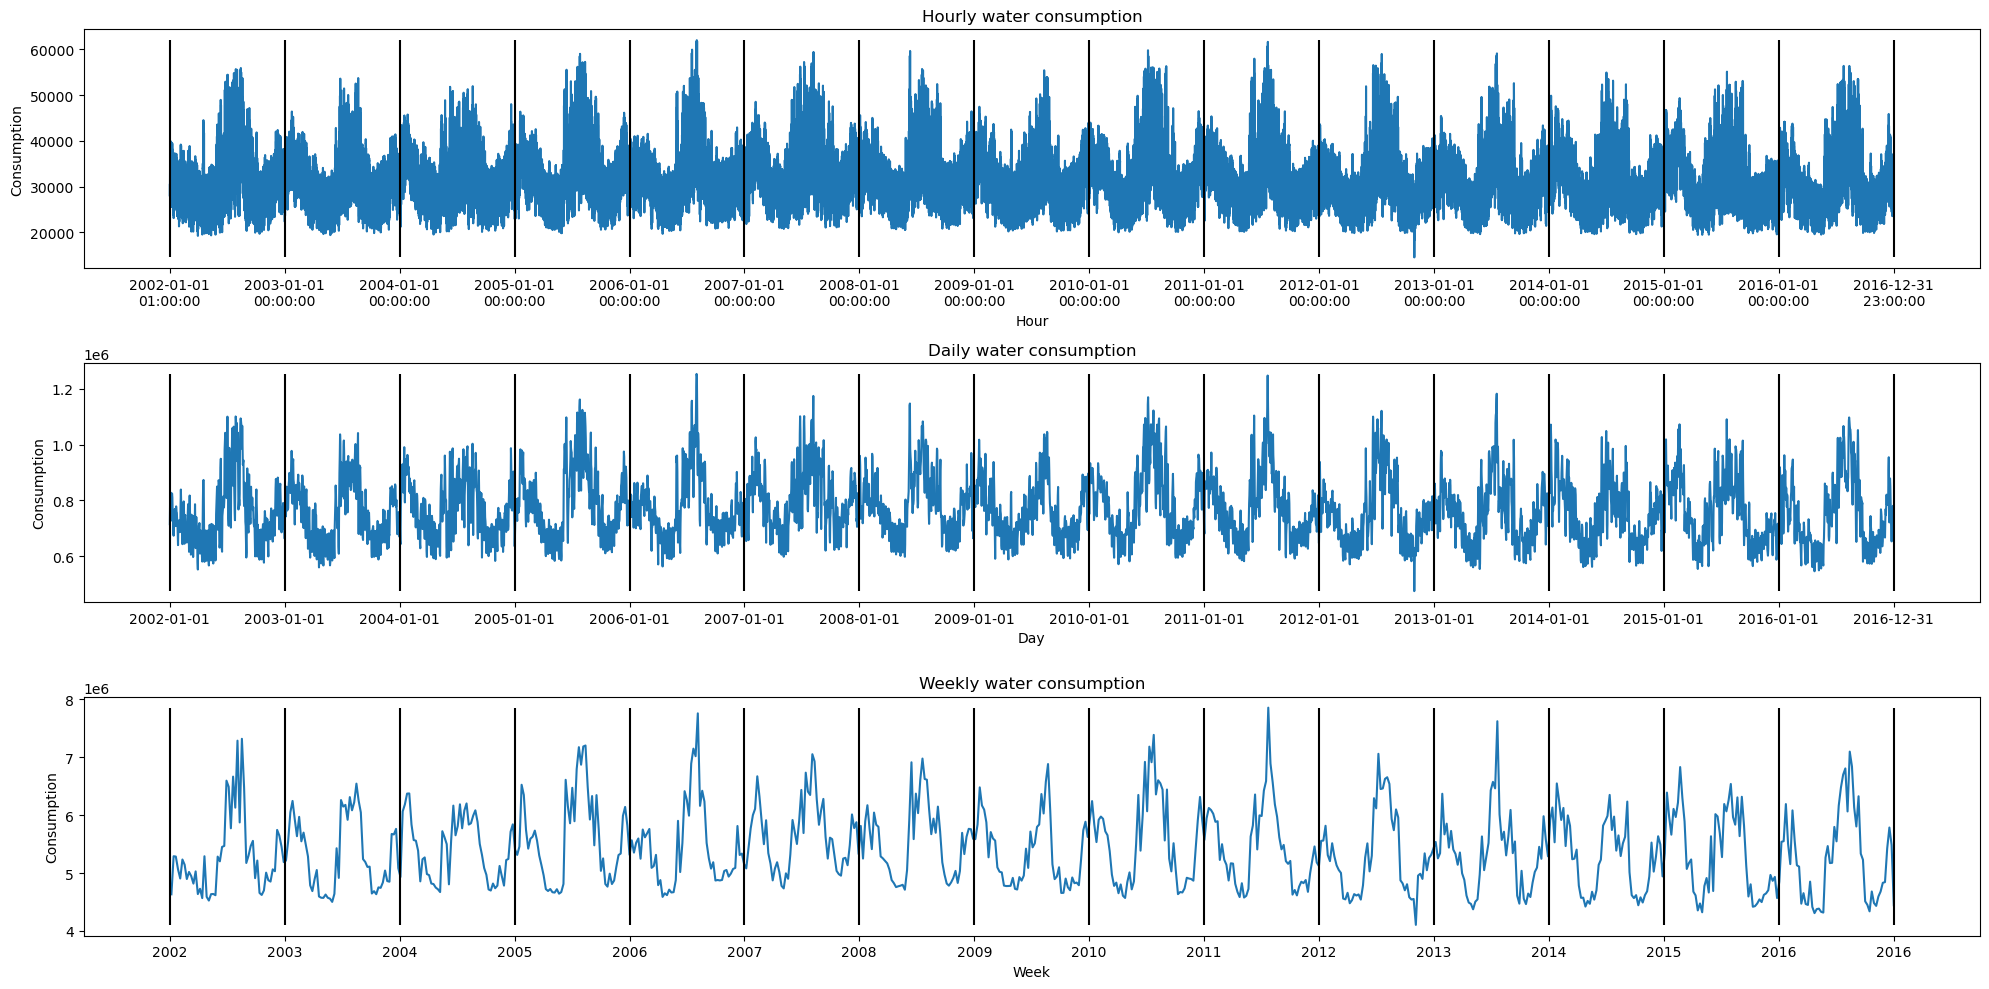

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

# HOURLY

# Get the dates
dates = water_data.index

# Plot only the first labels of each year
xticks1 = [dates[0]] + dates[(dates.hour == 0) & (dates.day == 1) & (dates.month == 1)].tolist() + [dates[-1]]

axes[0].plot(water_data)
axes[0].set_xlabel("Hour")
axes[0].set_xticks(xticks1, [str(tick).split(" ")[0] + "\n"+str(tick).split(" ")[1] for tick in xticks1])

# Add vertical lines to each year
axes[0].vlines(xticks1, ymin=water_data.min(), ymax=water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[0].set_ylabel("Consumption")
axes[0].set_title("Hourly water consumption")

# DAILY

daily_water_data = water_data.resample('D').sum()

axes[1].plot(daily_water_data)
axes[1].set_xlabel("Day")
axes[1].set_xticks(xticks1)

# Add vertical lines to each year
axes[1].vlines(xticks1, ymin=daily_water_data.min(), ymax=daily_water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[1].set_ylabel("Consumption")
axes[1].set_title("Daily water consumption")

# WEEKLY

weekly_water_data = water_data.resample('W').sum()

axes[2].plot(weekly_water_data)
axes[2].set_xlabel("Week")
axes[2].set_xticks(xticks1, [str(tick).split("-")[0] for tick in xticks1])

# Add vertical lines to each year
axes[2].vlines(xticks1, ymin=weekly_water_data.min(), ymax=weekly_water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[2].set_ylabel("Consumption")
axes[2].set_title("Weekly water consumption")

plt.tight_layout()
plt.show()

# Analize timeseries

## First plots

From a first point of view, we can suppose that the timeseries is stationary with a yearly seasonality component. Lets take a look closer, in an interval of one year, month and week:

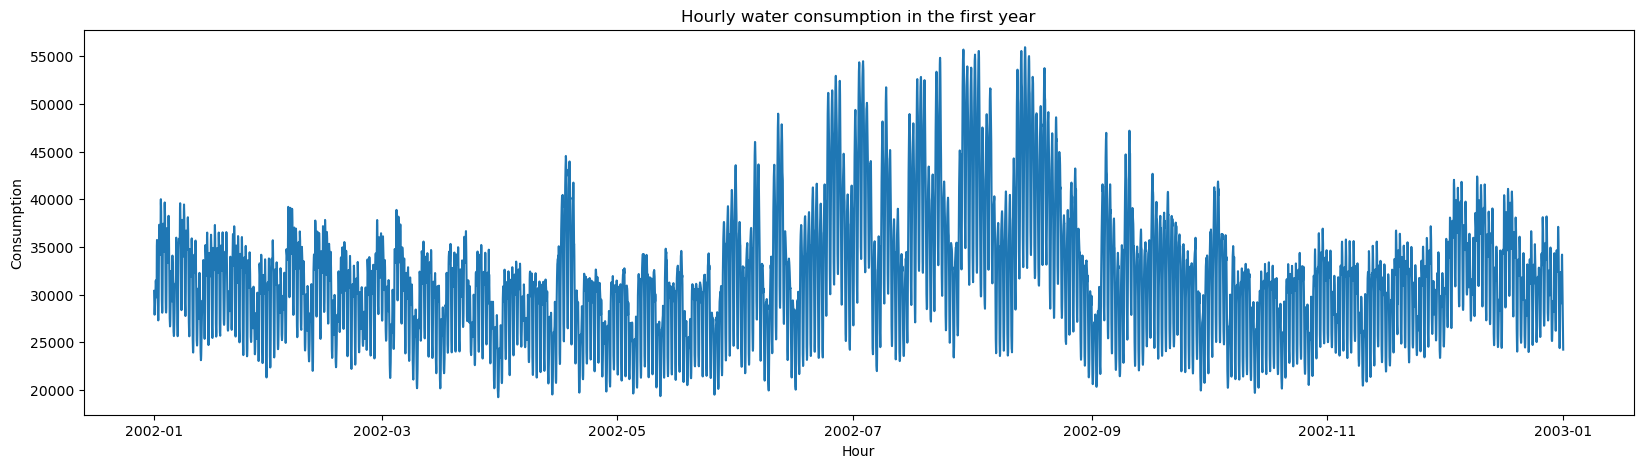

In [93]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*365))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first year")
plt.show()

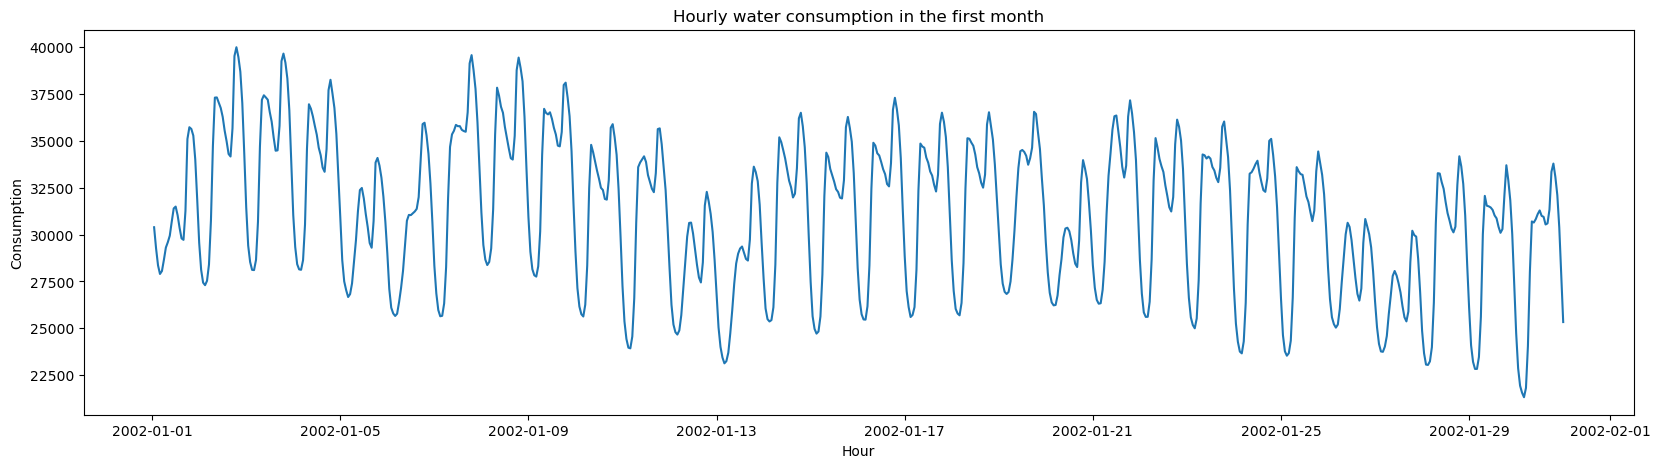

In [102]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*30))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first month")
plt.show()

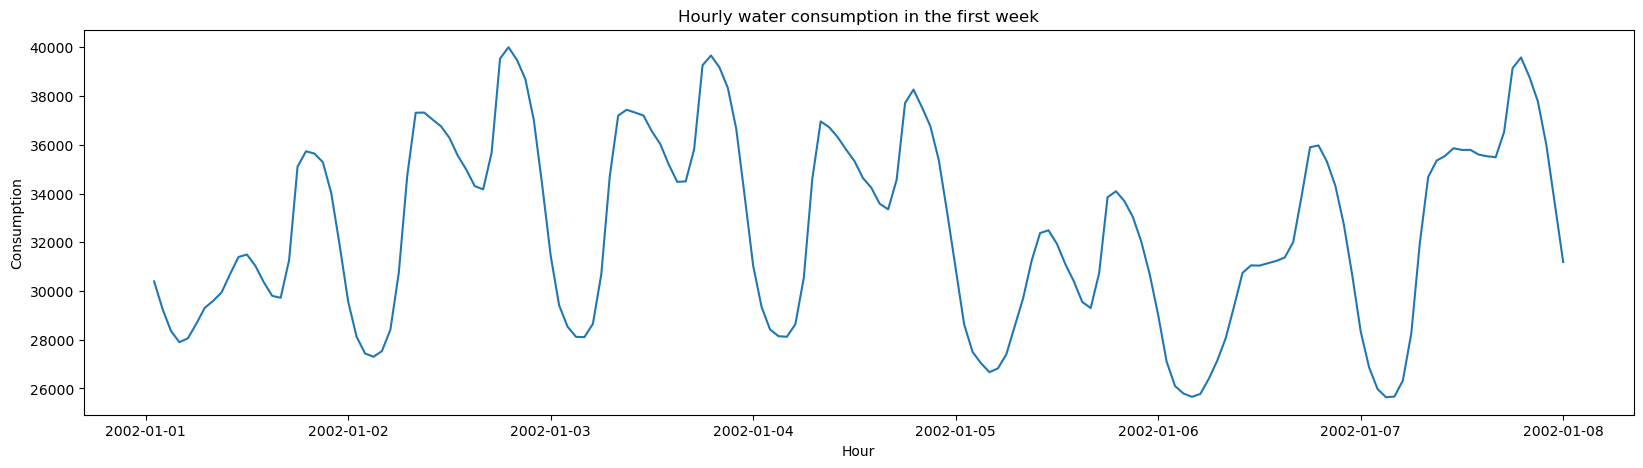

In [99]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*7))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first week")
plt.show()

It seems that it is likely for the timeseries to have a weekly and daily seasonality as well.

## Stationarity test

Lets first test for the **stationarity** of the timeseries. We use a statistical test which is called **Augmented Dickey-Fuller Test**. It uses the following **null** and **alternative** hypothesis:

H0: The time series is non-stationary.<br>
HA: The time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform augmented Dickey-Fuller test
adfuller(water_data["Consumption"])

(-17.99625443016976,
 2.7437745143145183e-30,
 73,
 131396,
 {'1%': -3.4303997688495524,
  '5%': -2.8615619971096953,
  '10%': -2.5667817082816686},
 1894789.6167218995)

The **p-value** is approximately **2.74*10^(-30)**, which means it is less than any common used significance level (for example 0.05). We conclude that we can reject the null hypothesis and consider our timeseries stationary

## Seasonality test

Lets make a periodogram to observe any periodicity (seasonality) in the timeseries

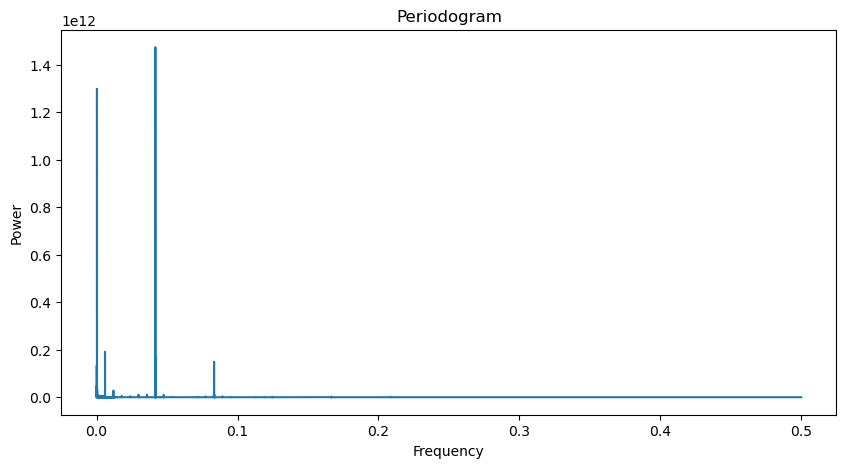

In [47]:
# Calculate the periodogram
frequencies, power = periodogram(water_data["Consumption"], fs=1)

plt.figure(figsize=(10,5))
plt.plot(frequencies, power)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Periodogram")
plt.show()

We can clearly see that there are some strong frequencies embeded in the series. Now lets convert them to periods to see what is actualy happening. We take the 5 most strong frequencies and convert them to periods, then we round them up:

In [ ]:
top5_index = np.argsort(power)[-5:][::-1]
print(f"Top 5 periods: {(1/frequencies[top5_index]).round()}", f"Top 5 powers {power[top5_index]}", sep="\n")

Top 5 periods: [  24. 4382.  168.   24.   12.]
Top 5 powers [1.47401199e+12 1.29873070e+12 1.91752706e+11 1.70919506e+11
 1.49095432e+11]


After we round up the values of the periods, we get the following results: 
1. The most strong periodic component has period = 24 (Daily seasonality) 
2. The second strongest periodic component has period = 4382 (almost half year seasonality, half year has 4380 hours) 
3. The third strongest periodic component has period = 168 (Weekly seasonality, 1 week has 168 hours)
4. The fourth strongest periodic component has again period = 24 (possibly the 24 period has a compound periodicity)
5. The fifth strongest periodic component has period = 12 (half day seasonality)

## Component decomposition